In [1]:
import cobra
from cobra.io import load_json_model
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from rpcfba import *
from scipy import stats
from sklearn.metrics import r2_score

# Load data

In [2]:
model = load_json_model('../data/GSMM_parameters/LP_HMX2.json')
ptot_lpl=0.299
params = load_model_params('../data/GSMM_parameters/model_params.csv')
MRS = init_MRSmedium()
FpH_table = pd.read_csv('../data/GSMM_parameters/FpH.csv')

# FBA

In [8]:
growth_fixed = pd.read_excel('../data/Exp_data/Growth_pHcontrol_B.xlsx')
metab = pd.read_csv('../data/Exp_data/Metabolomics_mM.csv')
conv_factor = 0.35
def get_grs(od_list, time_step):
    output = []
    for i in range(len(od_list)-1):
        output.append( np.log(od_list[i+1]/od_list[i]) /time_step )
    return output  

def norm_rates(biomass, cons, time_step):
    output = []
    for i in range(len(biomass)-1):
        output.append( ((cons[i+1]-cons[i])/(biomass[i]/2+biomass[i+1]/2) )/time_step )
    return output

glc_rates_dict = {}
for x in [4.5, 5, 5.5, 6.5]:
    temp_pd = (growth_fixed[growth_fixed['pH']==x]).reset_index().drop(['index'],axis=1)
    biomass = np.mean( temp_pd.iloc[:,2:5].values, axis=1) * conv_factor
    temp_pd = (metab[metab['Sample']=='pH'+str(x)]).reset_index().drop(['index'],axis=1)
    avg = list(temp_pd['Glucose(avg)'])[:5]
    glc_rates = norm_rates(biomass[:5], avg, 2)
    glc_rates_dict[x] = glc_rates

In [9]:
max_grs = {4.5: 0.33518078911208254, 5: 0.41737210588433693, 5.5: 0.4753825089522112, 6.5: 0.5886210431486689}
EPS_MW = model.metabolites.EPS_c.formula_weight
max_EPS_rates = {4.5: 232.0583306382854, 5: 338.5890799468476, 
                 5.5: 225.26467128479936, 6.5: 160.84310034487967} #mg/L
exp_glc_rates = {4.5:8.5409,5:37.2736,5.5:43.8656,6.5:32.3261} #mmol/gDW*hr

def fba_nolac(model, params, pH):
    with model:
        model.medium = MRS
        set_LpPA( model, ptot_lpl, params, pH )
        fluxes = cobra.flux_analysis.pfba(model).fluxes
    return fluxes

In [10]:
pred_grs, pred_eps_rates, pred_glc = {}, {},{}
for pH in max_grs.keys():
    fluxes = fba_nolac(model, params, pH)
    pred_grs[pH] = fluxes['biomass_LPL60']
    pred_eps_rates[pH]=EPS_MW*fluxes['WZX']
    pred_glc[pH] = fluxes['GLCpts']

In [11]:
r2 =  r2_score( list(pred_grs.values()), list(max_grs.values()) )
print(r2)

r2 =  r2_score( list(pred_eps_rates.values()), list(max_EPS_rates.values()) )
print(r2)

r2 = r2_score(list(pred_glc.values()), list(exp_glc_rates.values()) )
print(r2)

0.5794847005291037
0.7748940234753275
-11.188932181239474


In [12]:
pH_list = np.linspace(4.4,6.6,40)
sim_grs,sim_eps_rates, sim_glc_rates=[],[],[]
for pH in pH_list:
    fluxes = fba_nolac(model, params, pH )
    sim_grs.append(fluxes['biomass_LPL60'])
    sim_eps_rates.append(EPS_MW*fluxes['WZX'])
    sim_glc_rates.append(fluxes['GLCpts'])

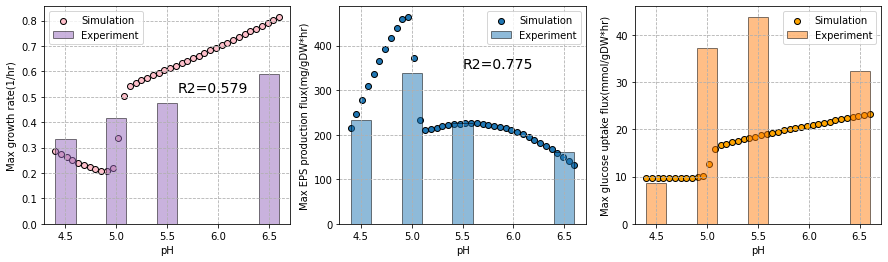

In [19]:
fig, axs = plt.subplots(1,3, figsize=(15,4))
axs[0].scatter(pH_list,sim_grs, color='pink',edgecolor='black', label='Simulation')
axs[0].bar(max_grs.keys(), max_grs.values(), color='tab:purple',
           width=0.2, alpha=0.5, edgecolor='black', label='Experiment')
axs[1].scatter(pH_list, sim_eps_rates,edgecolor='black', label='Simulation')
axs[1].bar(max_EPS_rates.keys(), max_EPS_rates.values(), color='tab:blue',
           width=0.2, alpha=0.5, edgecolor='black', label='Experiment')

axs[2].scatter(pH_list,sim_glc_rates, color='orange',edgecolor='black', label='Simulation')
axs[2].bar(exp_glc_rates.keys(), exp_glc_rates.values(), color='tab:orange',
           width=0.2, alpha=0.5, edgecolor='black', label='Experiment')

for ax in axs:
    ax.grid(linestyle='--')
    ax.legend()
    ax.set_xlabel('pH')
axs[0].set_ylabel('Max growth rate(1/hr)')
axs[1].set_ylabel('Max EPS production flux(mg/gDW*hr)')
axs[2].set_ylabel('Max glucose uptake flux(mmol/gDW*hr)')
axs[0].text(5.6,0.52,s='R2=0.579', fontsize=14)
axs[1].text(5.5,350,s='R2=0.775', fontsize=14)
# plt.savefig('../../../../EPS_LP/Figures/FBA_validation.svg',format='svg',dpi=150)

# FBA: change carbon sources (Glucose, Mannose, Lactose)

In [20]:
MRS = init_MRSmedium()
MRS_man = MRS.copy()
MRS_man['EX_glc_e'] = 0
MRS_man['EX_man_e'] = 100
MRS_lcts = MRS.copy()
MRS_lcts['EX_glc_e'] = 0
MRS_lcts['EX_lcts_e'] = 100

def fba_nolac(model, medium, params, pH):
    with model:
        model.medium = medium
        set_LpPA( model, ptot_lpl, params, pH )
        fluxes = cobra.flux_analysis.pfba(model).fluxes
    return fluxes

In [21]:
EPS_MW = model.metabolites.EPS_c.formula_weight
med_dict = {'Glucose':MRS, 'Mannose':MRS_man, 'Lactose':MRS_lcts}
pH_list = np.linspace(4.4,6.6,40)
sim_grs, sim_eps={'Glucose':[], 'Mannose':[], 'Lactose':[]},{'Glucose':[], 'Mannose':[], 'Lactose':[]};
for med_name in med_dict.keys():
    for pH in pH_list:
        f = fba_nolac(model, med_dict[med_name], params, pH)
        sim_grs[med_name].append(f['biomass_LPL60'])
        sim_eps[med_name].append(EPS_MW*f['WZX'])

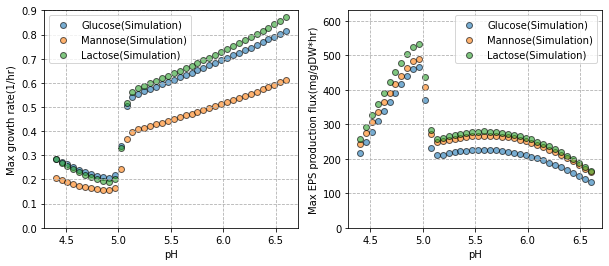

In [23]:
fig, axs = plt.subplots(1,2, figsize=(10,4))
for med_name in med_dict.keys():
    axs[0].scatter(pH_list, sim_grs[med_name], edgecolor='black',alpha=0.6, label=med_name+'(Simulation)')
for med_name in med_dict.keys():
    axs[1].scatter(pH_list, sim_eps[med_name], edgecolor='black',alpha=0.6, label=med_name+'(Simulation)')
for ax in axs:
    ax.grid(linestyle='--')
    ax.legend()
    ax.set_xlabel('pH')
axs[0].set_ylabel('Max growth rate(1/hr)')
axs[1].set_ylabel('Max EPS production flux(mg/gDW*hr)')
axs[0].set_ylim([0,0.9])
axs[1].set_ylim([0,630])
# plt.savefig('../../../../EPS_LP/Figures/FBA_perturbation.svg',format='svg',dpi=150)